In [1]:
library("metacell")
library("Matrix")
library("ggplot2")
library("ggrepel")
library("tgstat")
library("zoo")
library("qvalue")
library("devtools")
library("data.table")
library("tidyverse")
library("tglkmeans")
library('RColorBrewer')

setwd(here::here())
scdb_init("scrna_db/", force_reinit = T)


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: usethis

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v tibble  3.1.2      v dplyr   1.0.10
v tidyr   1.2.0      v stringr 1.4.0 
v readr   2.1.0      v forcats 1.0.0 
v purrr   0.3.4      

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x tidyr::expand()    masks Matrix::expand()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first()
x dplyr::lag()       masks stats::lag()
x dplyr::last()      masks data.table::last()
x tidyr::pack()      masks Matrix::pack()
x purrr::transpose() masks data.table::transpose()
x tidyr::unpack()    masks Matrix::unpack()

initializing scdb to scrna_db/



In [2]:
mat_e45 <- scdb_mat("embexe_with_e45")
mc_e45 <- scdb_mc("embexe_with_e45")

mat <- scdb_mat("embexe")
mc <- scdb_mc("embexe_recolored")

mat_exe <- scdb_mat("exe")
mc_exe <- scdb_mc("exe")

In [3]:
md_e45 <- mat_e45@cell_metadata[names(mc_e45@mc),]
md <- mat@cell_metadata[names(mc@mc),]

In [4]:
color_key <- mc@color_key

col_to_ct = color_key$group
names(col_to_ct) = color_key$color

ct_to_col = color_key$color
names(ct_to_col) = color_key$group

shades_rdbu <- rev(colorRampPalette(RColorBrewer::brewer.pal(11,name = "RdBu"))(100))
shades_blues <- colorRampPalette(RColorBrewer::brewer.pal(9,"Blues"))(100)
shades_grey <- colorRampPalette(RColorBrewer::brewer.pal(9,"Greys"))(100)

In [5]:
cls_old <- intersect(names(mc_exe@mc),colnames(mat@mat))
message("Number of E5.5-8.5 cells = ", length(cls_old))

cls_old_exe <- cls_old[mc_exe@colors[mc_exe@mc[cls_old]] %in% color_key$color[c(43:48)]]
message("Number of E5.5-8.5 EXE cells = ", length(cls_old_exe))

mcs_old_exe <- unique(mc_exe@mc[cls_old_exe])

Number of E5.5-8.5 cells = 8691

Number of E5.5-8.5 EXE cells = 8543



In [6]:
annotation_col = data.frame(ct = col_to_ct[mc_exe@colors],stringsAsFactors = F)
rownames(annotation_col) = colnames(mc_exe@e_gc)
annotation_colors = list(ct = ct_to_col)

In [7]:
# filtered_mcs = c(mcs_old_exe, mcs_e45_exe, mcs_e45_emb)
filtered_mcs = c(mcs_old_exe)
md_exe <- mat_exe@cell_metadata[names(mc_exe@mc),]

In [8]:
sc_age <- md_exe[names(mc_exe@mc)[as.numeric(mc_exe@mc) %in% filtered_mcs],"developmental_time"]
names(sc_age) <- names(mc_exe@mc)[as.numeric(mc_exe@mc) %in% filtered_mcs]
sc_age <- sc_age[!is.na(sc_age)]
sc_age <- sc_age[order(sc_age)]

mc_age <- tapply(sc_age, mc_exe@mc[names(sc_age)],mean)
mc_age <- mc_age[intersect(names(mc_age),as.character(filtered_mcs))]
mc_age <- mc_age[order(mc_age)]

In [9]:
find_mcs <- function(color){
    Ct = color_key[color_key$color == color,"group"]
    Ct_nm_adjust <- gsub("/| |-", replacement = "_", x = Ct)
    
    mcs <- which(mc_exe@colors == color)
    mcs <- intersect(mcs, filtered_mcs)
    mcs_ord_by_time <- mc_age[as.character(mcs)]
    mcs_ord_by_time <- mcs_ord_by_time[order(mcs_ord_by_time)]
    
    assign(x = sprintf("mcs_%s", tolower(Ct_nm_adjust)), value = names(mcs_ord_by_time), envir = .GlobalEnv)
}

for(col in unique(mc_exe@colors[filtered_mcs])){find_mcs(col)}

png 
  2

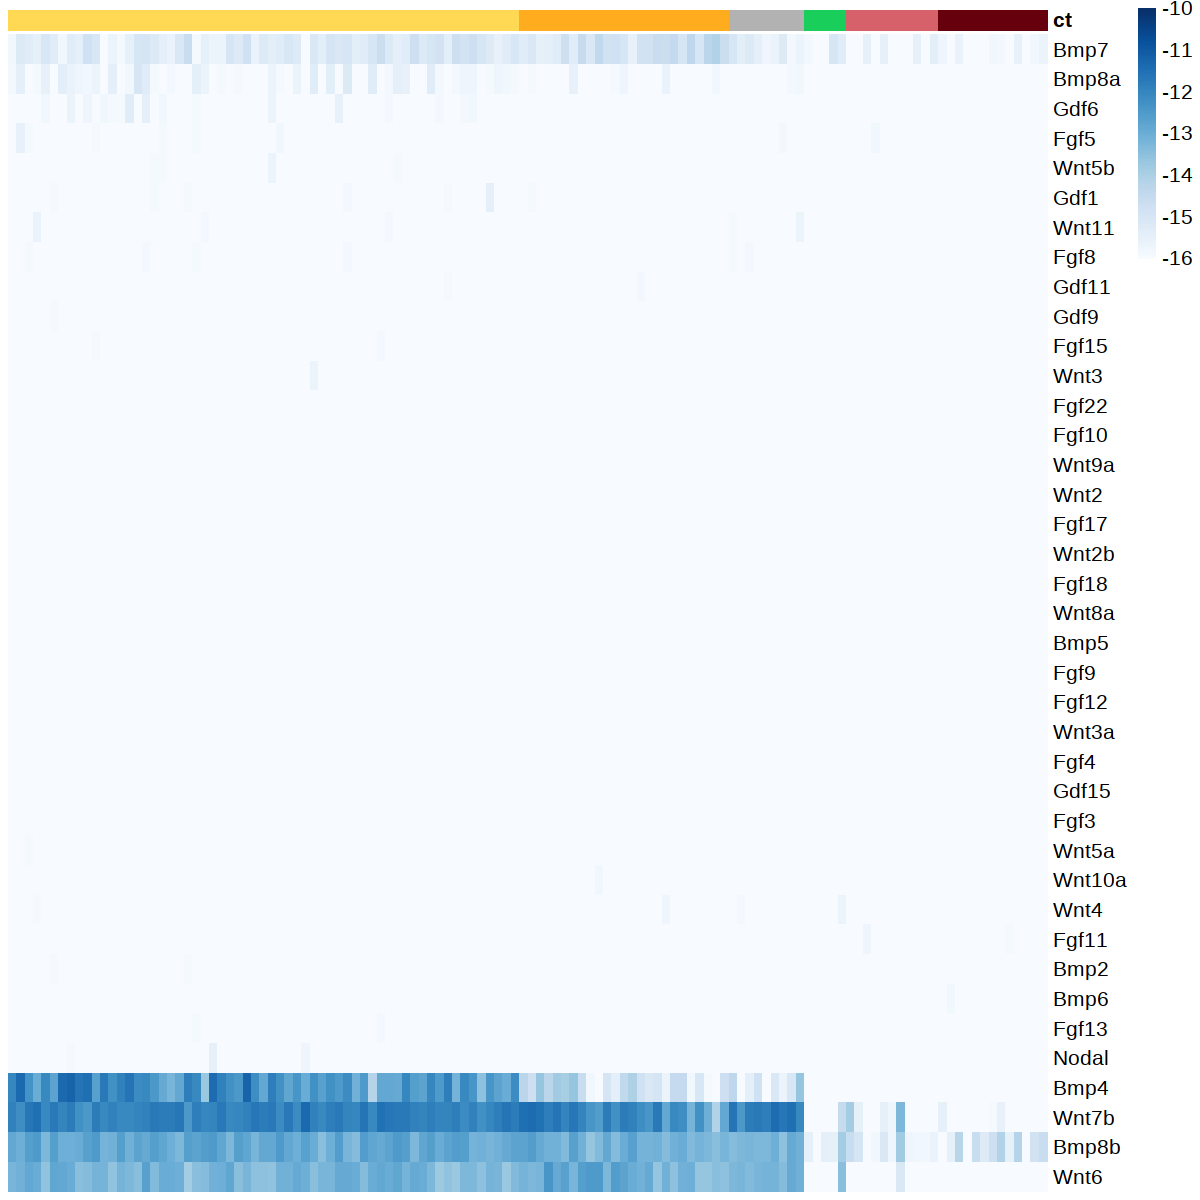

In [10]:
filtered_mcs_ORD <- c(mcs_chorion_progenitors, mcs_chorion, mcs_intermediate_chorion, mcs_spt_gly, mcs_epc_progenitors, mcs_tgc_progenitors)

# gns <- c("Ascl2","Eomes","Fgfr2","Adm","Fosl1","Chsy1","Sox2","Pcdh12","Hand1", "Bmp4")
gns <- c(grep("bmp[1-9]",rownames(mc_exe@e_gc),ignore.case = T, v = T),grep("tgf[1-9]",rownames(mc_exe@e_gc),ignore.case = T, v = T),
        grep("fgf[1-9]",rownames(mc_exe@e_gc),ignore.case = T, v = T),grep("wnt[1-9]",rownames(mc_exe@e_gc),ignore.case = T, v = T),
        grep("gdf[1-9]",rownames(mc_exe@e_gc),ignore.case = T, v = T),grep("nodal",rownames(mc_exe@e_gc),ignore.case = T, v = T))
gns <- setdiff(gns,c("Bmp1","Bmp2k"))

legc <- log2(mc_exe@e_gc[gns,filtered_mcs_ORD] + 1e-5) 
lfc <- legc - rowMeans(legc)
options(repr.plot.width=10, repr.plot.height=10)
breaks = seq(-16,-10,length.out = 101)
# breaks = seq(-6,6,length.out = 101)
p <- pheatmap::pheatmap(legc,fontsize = 12,
                   cluster_rows = T,
                   breaks = breaks,
                   cluster_cols = F,
                   color = shades_blues,
                   annotation_col = annotation_col,
                   annotation_colors = annotation_colors,
                   annotation_legend = F,
                   treeheight_row = 0, 
                   treeheight_col = 0,
                   border_color = NA, 
                   show_rownames = T, 
                   show_colnames = F)

pdf("figs/heat_ligands_exe.pdf", width = 8, height = 4, useDingbats = F)
print(p)
dev.off()

png 
  2

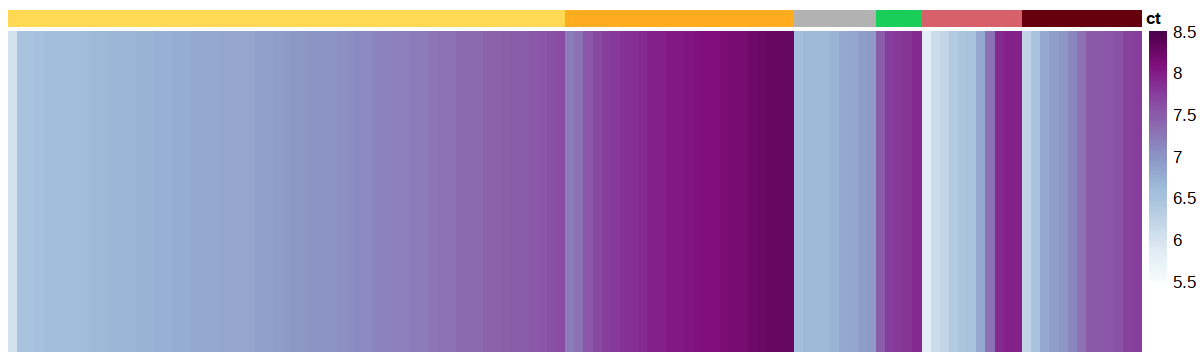

In [12]:
mc_age_ord <- mc_age[filtered_mcs_ORD]
mc_age_ord.df <- as.data.frame(mc_age_ord)

options(repr.plot.width=10, repr.plot.height=3)
breaks = seq(5.5,8.5,length.out = 101)

p <- pheatmap::pheatmap(t(mc_age_ord.df),
                   cluster_rows = F,
                   breaks = breaks,
                   cluster_cols = F,
                   color = colorRampPalette(RColorBrewer::brewer.pal(9,"BuPu"))(100),
                   annotation_col = annotation_col,
                   annotation_colors = annotation_colors,
                   annotation_legend = F,
                   treeheight_row = 0, 
                   treeheight_col = 0,
                   border_color = NA, 
                   show_rownames = F, 
                   show_colnames = F)

pdf("figs/heat_fig3g_age_legend.pdf", width = 8, height = 4, useDingbats = F)
print(p)
dev.off()

In [105]:
qPCR = read.table("~/wd_NEW/qPCR_explants.csv", sep = ",", header = T)
library(stats)

# Initialize an empty data frame to store the results
results <- data.frame()

# Loop through each gene
unique_genes <- unique(qPCR$gene)
for (gene in unique_genes) {
  # Subset the data for the current gene
  gene_data <- qPCR[qPCR$gene == gene,]
  
  # Perform a paired t-test
    t_test <- t.test(value ~ group, data = gene_data, paired = FALSE)
    
  # Store the results in the data frame
  results <- rbind(results, data.frame(
    gene = gene,
    pval_t = t_test$p.value))
}

results

gene,pval_t
<chr>,<dbl>
Pcdh12,0.09844327
Ascl2,0.01841652
Chsy1,0.02470862
Adm,0.04239596
Hand1,0.26990083
